# Project 12

## Introduction

Social media platforms have become a crucial arena for public debate, political communication, and information exchange. However, their open and networked nature also makes them vulnerable to manipulation and coordinated influence campaigns. One of the most prominent examples of such activity is the operation of Russian “troll” accounts on Twitter, which aimed to influence political discourse in the United States and other countries.

According to investigations by NBC News and Neo4j, these accounts were part of organized efforts linked to the Internet Research Agency (IRA). The trolls were not homogeneous: instead, they represented different personas, political positions, and communication strategies. Their activity included spreading political propaganda, amplifying divisive content, impersonating grassroots activists, and coordinating messages across multiple accounts.

The publicly released dataset of deleted Russian troll tweets provides a unique opportunity to analyze these behaviors from a network science perspective. By constructing retweet, mention, and hashtag networks, we can identify structural patterns, behavioral roles, and thematic focuses of different troll types. Such analysis helps to better understand how coordinated disinformation campaigns operate in online social networks.

## What type pf trolls are in the database?

Based on prior investigations (NBC News; Neo4j) and expected patterns in the dataset, the following types of trolls can be identified:

1. Political propaganda trolls

These accounts primarily post and amplify politically charged content related to elections, political parties, candidates, and controversial policies. They often retweet ideological messages and link to external political websites.

2. Identity-based trolls

These trolls impersonate members of specific social groups (e.g. activists, minorities, veterans). Their goal is to create emotional engagement and increase polarization by posting content framed as grassroots opinions.

3. Amplifier (bot-like) trolls

These accounts rarely produce original content. Instead, they mainly retweet or repost messages from other troll accounts, helping selected narratives gain visibility.


4. News-spreading trolls

Some trolls focus on sharing links to news articles or pseudo-news sites. They act as distributors rather than commentators, often pushing sensational or misleading headlines.

## How to tell them apart?

Different troll types can be distinguished using network structure and activity patterns:

* Retweet network position

    * High out-degree → amplifiers

    * High in-degree → influential propaganda accounts

* Content originality

    * Many original tweets → propaganda or identity-based trolls

    * Mostly retweets → amplifier trolls

* Hashtag usage

    * Strongly ideological or identity-focused hashtags → political or identity trolls

    * Repeated use of the same hashtags → coordinated behavior

* Mention behavior

    * Frequent mentions of politicians or media accounts → political trolls

    * Few mentions, mostly retweets → amplifiers

These characteristics allow troll categories to be identified without prior labeling, purely from behavioral and network features.

## Hashtags

Based on the linked investigations and expected dataset patterns, trolls commonly use:

* Political hashtags (elections, candidates, parties)

* Identity-focused hashtags related to race, ideology, or social movements

* Emotion-driven hashtags designed to provoke outrage or solidarity

* Event-based hashtags tied to debates, protests, or breaking news

## Analysis

### Imports and data loading

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import ast

In [3]:
tweets = pd.read_csv("./data/tweets.csv")
users = pd.read_csv("./data/users.csv")

In [4]:
tweets.head()

,user_id,user_key,created_at,created_str,retweet_count,retweeted,favorite_count,text,tweet_id,source,hashtags,expanded_urls,posted,mentions,retweeted_status_id,in_reply_to_status_id
0,2.532612e+09,kathiemrr,1.488207e+12,2017-02-27 14:54:00,NaN,NaN,NaN,#ThingsDoneByMistake kissing auntie in the lips,8.362279e+17,NaN,"[""ThingsDoneByMistake""]",[],POSTED,[],NaN,NaN
1,2.531160e+09,traceyhappymom,1.471273e+12,2016-08-15 14:50:20,NaN,NaN,NaN,RT @mc_derpin: #TheOlderWeGet the more pessimi...,7.651989e+17,NaN,"[""TheOlderWeGet""]",[],POSTED,[],NaN,NaN
2,NaN,evewebster373,1.435701e+12,2015-06-30 21:56:09,NaN,NaN,NaN,RT @dmataconis: Ready To Feel Like A Failure? ...,6.160023e+17,NaN,[],[],POSTED,[],NaN,NaN
3,4.840552e+09,blacktolive,1.474013e+12,2016-09-16 08:04:48,18.0,False,17.0,Amen! #blacklivesmatter https://t.co/wGffaOqgzl,7.766933e+17,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","[""Blacklivesmatter""]",[],POSTED,[],NaN,NaN
4,1.694026e+09,jacquelinisbest,1.474228e+12,2016-09-18 19:46:25,0.0,False,0.0,RT @NahBabyNah: Twitchy: Chuck Todd caught out...,7.775946e+17,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","[""WakeUpAmerica""]","[""http://ln.is/twitchy.com/loriz-31/3yafU""]",POSTED,"[""nahbabynah""]",7.775915e+17,NaN


In [5]:
users.head()

,id,location,name,followers_count,statuses_count,time_zone,verified,lang,screen_name,description,created_at,favourites_count,friends_count,listed_count
0,100345056.0,still ⬆️Block⤵️Corner⬇️street,#Ezekiel2517✨...,1053.0,31858.0,NaN,False,en,SCOTTGOHARD,CELEBRITY TRAINER ✨#424W147th✨ #CrossfitCoach ...,Tue Dec 29 23:15:22 +0000 2009,2774.0,1055.0,35.0
1,247165706.0,"Chicago, IL",B E C K S T E R✨,650.0,6742.0,Mountain Time (US & Canada),False,en,Beckster319,Rebecca Lynn Hirschfeld Actress.Model.Writer.A...,Fri Feb 04 06:38:45 +0000 2011,7273.0,896.0,30.0
2,249538861.0,NaN,Chris Osborne,44.0,843.0,NaN,False,en,skatewake1994,NaN,Wed Feb 09 07:38:44 +0000 2011,227.0,154.0,1.0
3,449689677.0,NaN,Рамзан Кадыров,94773.0,10877.0,Moscow,False,ru,KadirovRussia,"Пародийный аккаунт. Озвучиваю то, что политика...",Thu Dec 29 11:31:09 +0000 2011,0.0,7.0,691.0
4,471868887.0,"Санкт-Петербург, Россия",Маргарита Саваж,23305.0,18401.0,Volgograd,False,ru,MargoSavazh,Честь имею. Нагло врать не умею.,Mon Jan 23 10:26:25 +0000 2012,1480.0,8021.0,231.0


In [6]:
tweets.columns

Index(['user_id', 'user_key', 'created_at', 'created_str', 'retweet_count',
       'retweeted', 'favorite_count', 'text', 'tweet_id', 'source', 'hashtags',
       'expanded_urls', 'posted', 'mentions', 'retweeted_status_id',
       'in_reply_to_status_id'],
      dtype='object')

In [7]:
users.columns

Index(['id', 'location', 'name', 'followers_count', 'statuses_count',
       'time_zone', 'verified', 'lang', 'screen_name', 'description',
       'created_at', 'favourites_count', 'friends_count', 'listed_count'],
      dtype='object')

### Hashtags

In [8]:
tweets.dtypes

user_id                  float64
user_key                  object
created_at               float64
created_str               object
retweet_count            float64
retweeted                 object
favorite_count           float64
text                      object
tweet_id                 float64
source                    object
hashtags                  object
expanded_urls             object
posted                    object
mentions                  object
retweeted_status_id      float64
in_reply_to_status_id    float64
dtype: object

In [9]:
def parse_list(x):
    if pd.isna(x) or x == "":
        return []
    return ast.literal_eval(x)

tweets["hashtags"] = tweets["hashtags"].apply(parse_list)

In [10]:
tweets["hashtags"].head()

0    [ThingsDoneByMistake]
1          [TheOlderWeGet]
2                       []
3       [Blacklivesmatter]
4          [WakeUpAmerica]
Name: hashtags, dtype: object

In [11]:
type(tweets["hashtags"].iloc[0])

list

In [12]:
from collections import Counter

hashtags = []

for hs in tweets["hashtags"]:
    hashtags.extend([h.lower() for h in hs])

Counter(hashtags).most_common(10)


[('politics', 3606),
 ('maga', 3079),
 ('trump', 2425),
 ('tcot', 2366),
 ('news', 1973),
 ('neverhillary', 1375),
 ('pjnet', 1276),
 ('trumppence16', 980),
 ('trump2016', 947),
 ('merkelmussbleiben', 796)]

In [13]:
freqs = dict(Counter(hashtags).most_common(50))

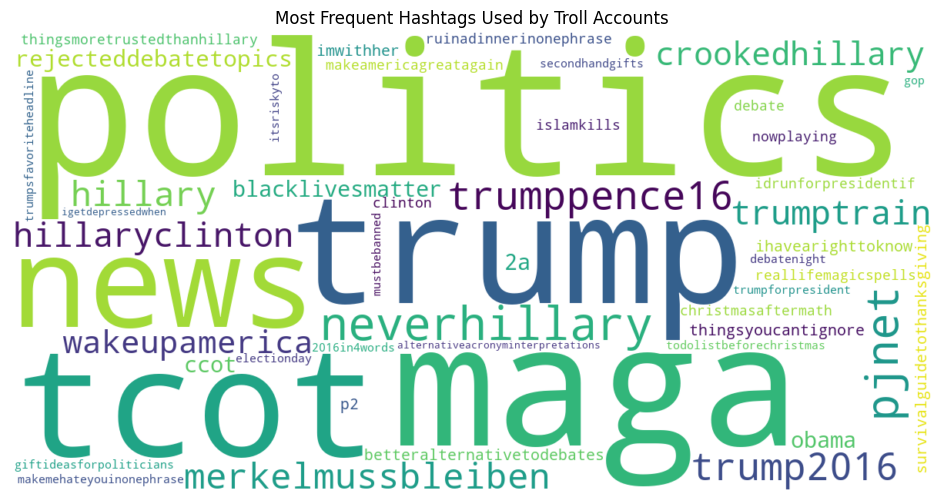

In [14]:
wc = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    max_words=50
)

wc.generate_from_frequencies(freqs)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Hashtags Used by Troll Accounts")
plt.show()


* Strong dominance of pro-Trump political hashtags (maga, trump, trumppence16)

* Clear anti-Hillary messaging (neverhillary)

* Use of conservative network hashtags (tcot, pjnet)

* Presence of international political content (merkelmussbleiben)

* Indicates coordinated political campaigning, not random posting

## Network

In [15]:
id_cols = [
    "user_id",
    "tweet_id",
    "retweeted_status_id",
    "in_reply_to_status_id"
]

for col in id_cols:
    tweets[col] = tweets[col].dropna().astype(str)

In [16]:
G_rt = nx.DiGraph()

for _, row in tweets.iterrows():
    user = row["user_id"]
    rt = row["retweeted_status_id"]

    if isinstance(rt, str) and rt.strip() != "":
        G_rt.add_edge(user, rt)


In [17]:
G_rt.number_of_nodes(), G_rt.number_of_edges()


(32664, 39082)

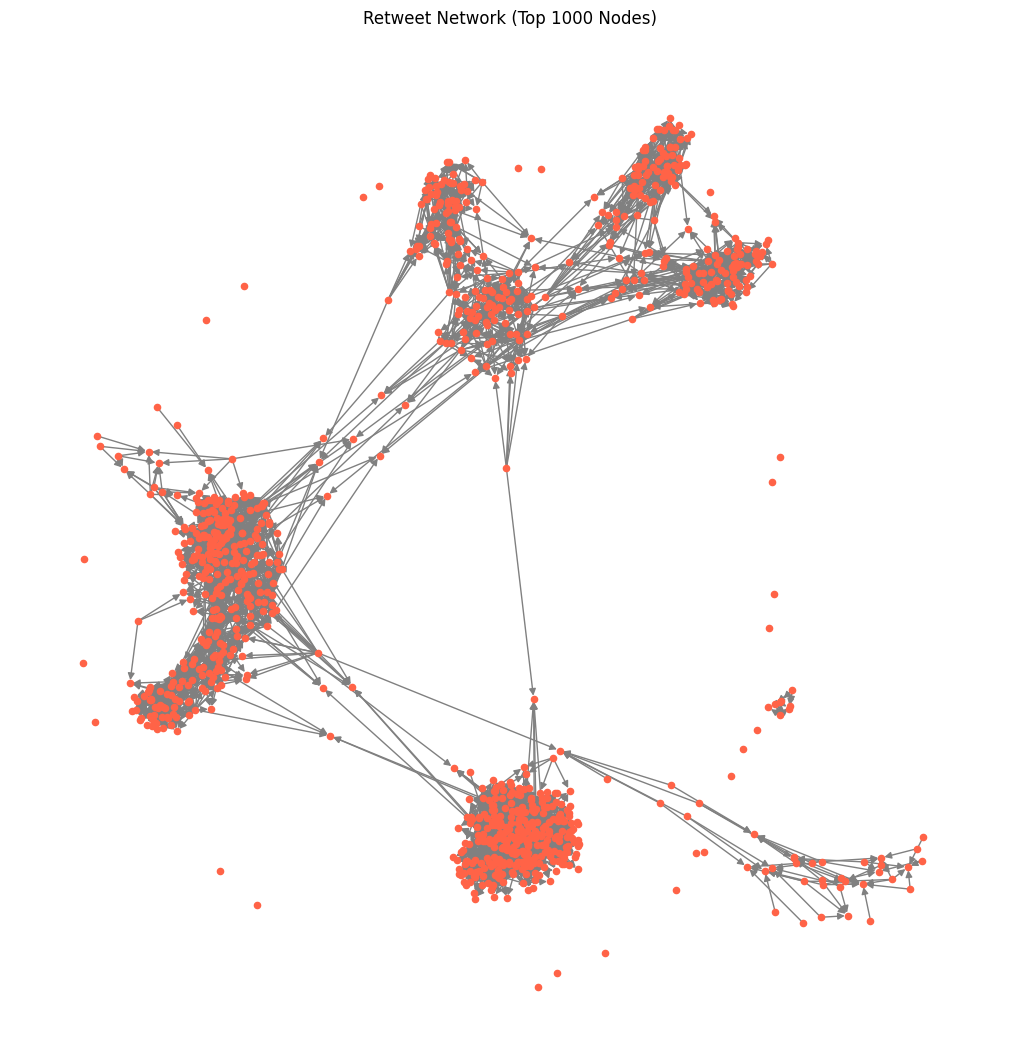

In [18]:
top_nodes = sorted(G_rt.degree, key=lambda x: x[1], reverse=True)[:1000]
H = G_rt.subgraph([n for n, _ in top_nodes])

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(H, seed=42)

nx.draw(
    H,
    pos,
    node_size=20,
    node_color="tomato",
    edge_color="gray",
    with_labels=False
)

plt.title("Retweet Network (Top 1000 Nodes)")
plt.show()


Figure shows the retweet network at the tweet level, restricted to the 1000 most frequently retweeted tweets. The network exhibits a clear clustered structure, with dense groups of tweets connected by numerous retweet edges. These clusters represent sets of tweets that are repeatedly amplified together, indicating coordinated dissemination of specific narratives rather than independent information sharing.

In [39]:
import re

def extract_rt_user(text):
    if isinstance(text, str):
        m = re.match(r"RT @([A-Za-z0-9_]+)", text)
        if m:
            return m.group(1).lower()
    return None

tweets["rt_user"] = tweets["text"].apply(extract_rt_user)


In [40]:
G_user = nx.DiGraph()

for _, row in tweets.iterrows():
    src = row["user_key"]
    tgt = row["rt_user"]

    if pd.notna(src) and tgt is not None:
        G_user.add_edge(src.lower(), tgt)

In [41]:
pr = nx.pagerank(G_user, alpha=0.85)

In [42]:
deg = dict(G_user.out_degree())

comparison = pd.DataFrame({
    "pagerank": pr,
    "out_degree": deg
}).fillna(0)

comparison.sort_values("pagerank", ascending=False).head(10)


,pagerank,out_degree
realdonaldtrump,0.000308,0
romaacorn,0.000275,0
tina_kandelaki,0.000189,0
rt_america,0.000167,0
rt_com,0.000159,0
tagesschau,0.000103,0
nevskyalexandr,0.000103,0
a_malahov,0.000089,0
wikileaks,0.000084,0
welt,0.000082,0


The observation that most high-PageRank users have zero out-degree reflects their role as content sources rather than amplifiers. These accounts are heavily retweeted by other users but do not themselves retweet others. Since PageRank rewards incoming links from structurally important nodes, such users achieve high PageRank values despite minimal retweet activity. This pattern is consistent with a centralized amplification strategy typical of coordinated influence campaigns.

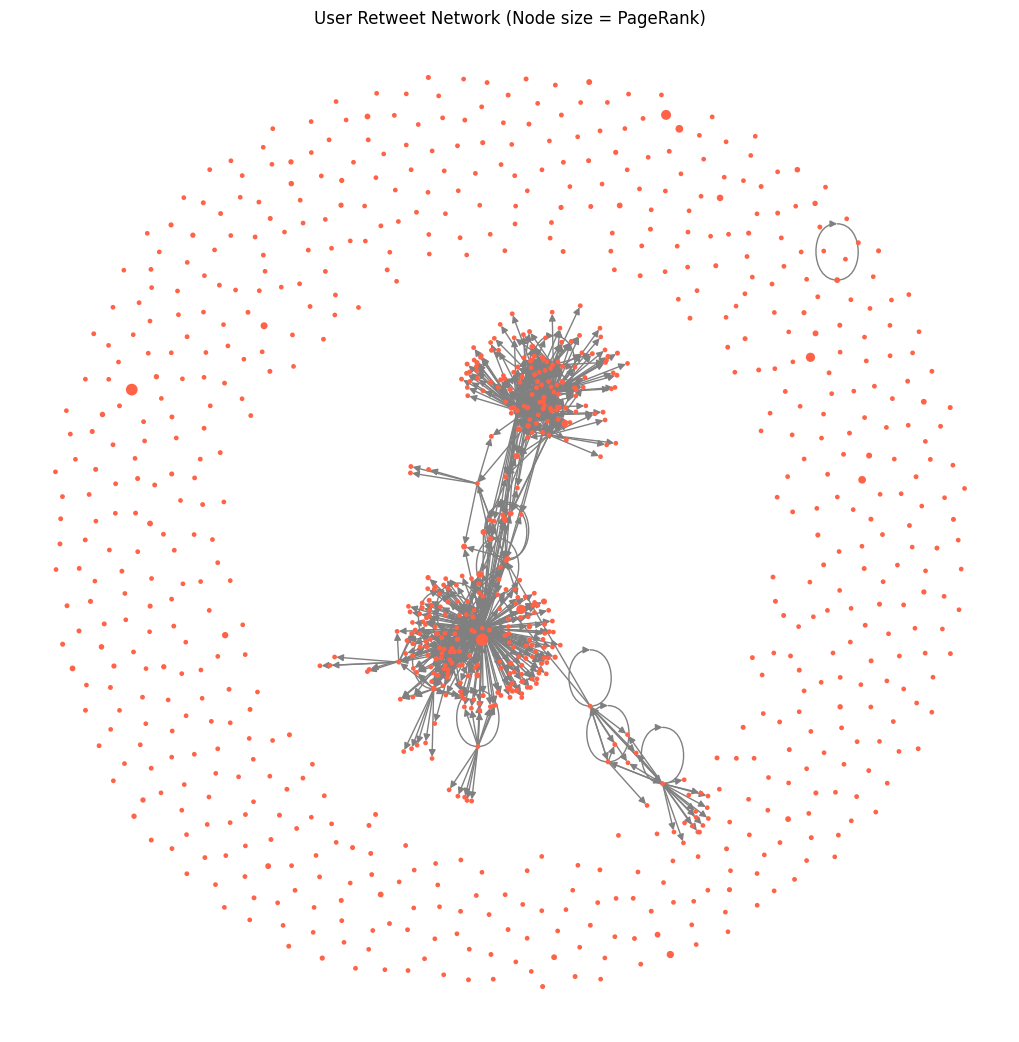

In [47]:
top_nodes = sorted(pr, key=pr.get, reverse=True)[:1000]
H = G_user.subgraph(top_nodes)

sizes = [pr[n] * 200000 for n in H.nodes()]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(H, seed=42)

nx.draw(
    H, pos,
    node_size=sizes,
    node_color="tomato",
    edge_color="gray",
    with_labels=False
)

plt.title("User Retweet Network (Node size = PageRank)")
plt.show()

This figure presents the user-level retweet network, where node size is proportional to PageRank. The network reveals a highly centralized structure characterized by a small number of influential nodes surrounded by a large periphery of low-impact users. The largest nodes correspond to accounts that are repeatedly retweeted by other structurally important users, indicating their role as primary narrative sources.

Most peripheral nodes have very low PageRank values and appear weakly connected or isolated in the induced subgraph. These nodes represent amplifier accounts that primarily retweet central sources but are not themselves retweeted. The asymmetric structure highlights a clear division of roles between content originators and amplifiers, consistent with coordinated information-amplification strategies.

Some peripheral nodes have relatively large PageRank because PageRank is computed on the full network, while the plot shows only a filtered induced subgraph. Their importance comes from connections that are not visible in the plot.

In [35]:
H_clean = H.copy()
H_clean.remove_nodes_from(list(nx.isolates(H_clean)))

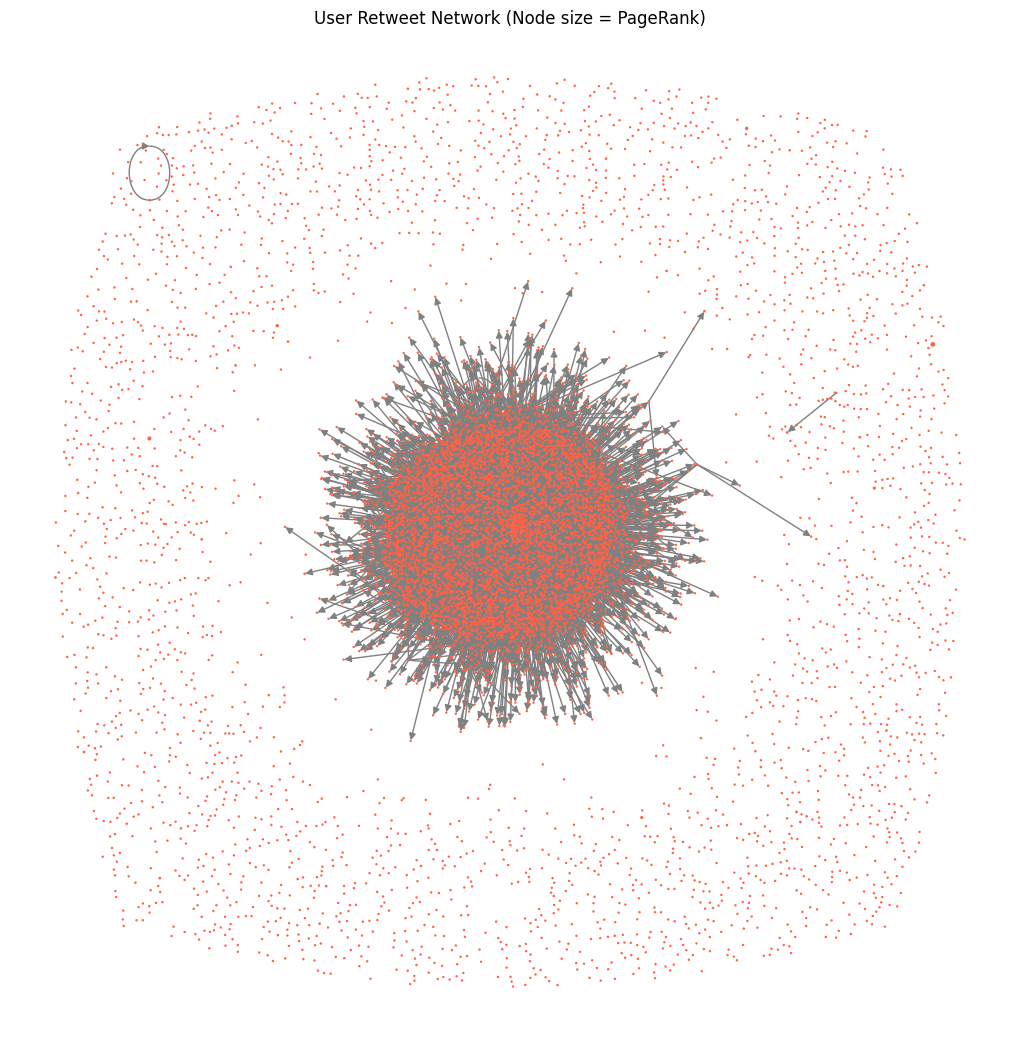

In [ ]:
top_nodes = sorted(pr, key=pr.get, reverse=True)[:10000]
H = G_user.subgraph(top_nodes)

sizes = [pr[n] * 20000 for n in H.nodes()]
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(H, seed=42)

nx.draw(
    H, pos,
    node_size=sizes,
    node_color="tomato",
    edge_color="gray",
    with_labels=False
)

plt.title("User Retweet Network (Node size = PageRank)")
plt.show()
